In [86]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torchvision.transforms import ToTensor
import torchvision.models as models

import os


In [87]:
writer = SummaryWriter('runs/flower_experiment_1')

In [88]:
# Define transformations for the df
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the flower df
flower_data = datasets.ImageFolder(root='flower_images', transform=transform)

In [89]:
# training and testing sets
total_size = len(flower_data)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_data, test_data = torch.utils.data.random_split(flower_data, [train_size, test_size])

In [90]:
# Print df details
print(train_data)
print(len(train_data))

3999


In [91]:
print(test_data)
print(len(test_data))

1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


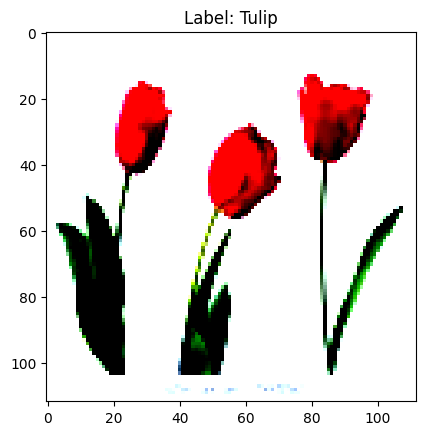

In [92]:
# Display an image of flower
sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]

flower_classes = ['Lily', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

plt.imshow(img.permute(1, 2, 0))
plt.title('Label: {}'.format(flower_classes[label]))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

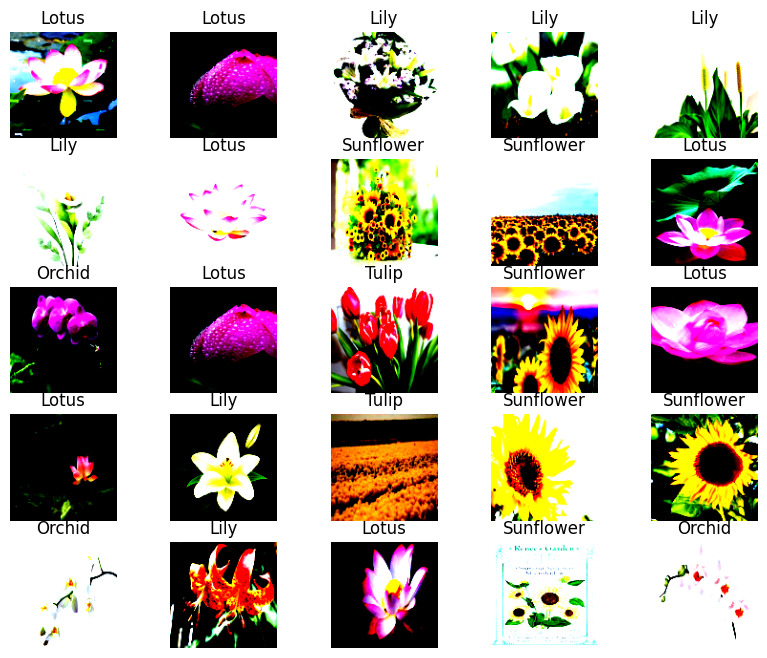

In [93]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(flower_classes[label]) 
    plt.axis("off")

    plt.imshow(img.permute(1, 2, 0))

plt.show()


In [94]:
# Create data loaders
flower_loaders = {
    'train': DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4),
}

In [95]:
dataiter = iter(flower_loaders['train'])
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
writer.add_image('flower_images', img_grid)


In [96]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.out = nn.Linear(512 * 7 * 7, 10) 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x


In [97]:
# Instantiate the CNN model
flower_cnn = CNN()
print(flower_cnn)
writer.add_graph(flower_cnn, images)
writer.close()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=25088, out_features=10, bias=True)
)


In [98]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [99]:
optimizer = optim.Adam(flower_cnn.parameters(), lr=0.001, weight_decay=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [100]:
num_epochs = 10

In [101]:
def train(num_epochs, cnn, loaders):
    run_loss = 0.0
    cnn.train()

    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            optimizer.zero_grad()

            loss.backward()
            run_loss += loss.item()
            optimizer.step()

            if i % 100 == 0:
                # record loss
                writer.add_scalar('training loss', run_loss / 100,
                            epoch * len(loaders['train']) + i)
                run_loss = 0.0

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass


In [102]:
# Train the flower CNN model
train(num_epochs, flower_cnn, flower_loaders)

Epoch [1/10], Step [100/125], Loss: 1.3853
Epoch [2/10], Step [100/125], Loss: 0.8235
Epoch [3/10], Step [100/125], Loss: 0.7272
Epoch [4/10], Step [100/125], Loss: 0.4769
Epoch [5/10], Step [100/125], Loss: 0.1981
Epoch [6/10], Step [100/125], Loss: 0.1606
Epoch [7/10], Step [100/125], Loss: 0.1349
Epoch [8/10], Step [100/125], Loss: 0.0724
Epoch [9/10], Step [100/125], Loss: 0.0444
Epoch [10/10], Step [100/125], Loss: 0.0230


In [103]:
# Save flower model
flower_save_dir = 'models/'
flower_model_name = 'flower_cnn.pt'
if not os.path.exists(flower_save_dir):
    os.makedirs(flower_save_dir)
torch.save(flower_cnn.state_dict(), flower_save_dir + flower_model_name)


In [104]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [105]:
def test(model, loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    accuracy = sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    plot_confusion_matrix(all_labels, all_preds, flower_classes)


Test Accuracy: 83.50%


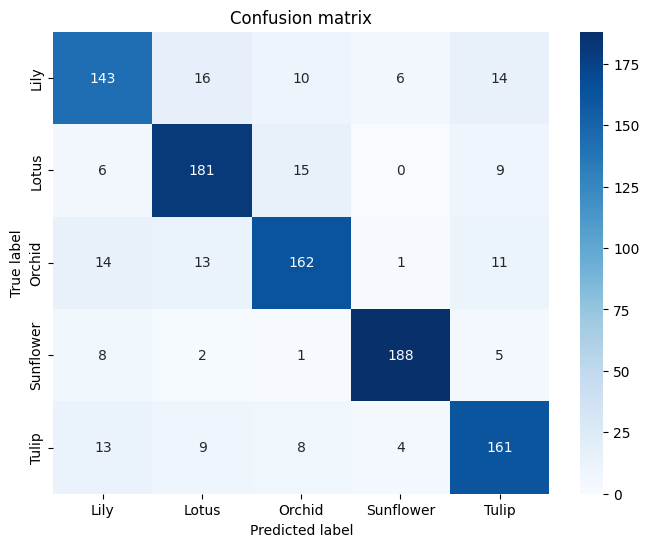

In [108]:
# Test the flower CNN model
test(flower_cnn, flower_loaders['test'])